# Reading raster files with Rasterio

[Rasterio](https://mapbox.github.io/rasterio/) is a highly useful module for raster processing which you can use for reading and writing [several different raster formats](http://www.gdal.org/formats_list.html) in Python. Rasterio is based on [GDAL](http://www.gdal.org/) and Python automatically registers all known GDAL drivers for reading supported
formats when importing the module. Most common file formats include for example [TIFF and GeoTIFF](http://www.gdal.org/frmt_gtiff.html),
[ASCII Grid](http://www.gdal.org/frmt_various.html#AAIGrid) and [Erdas Imagine .img](http://www.gdal.org/frmt_hfa.html) -files.


In [3]:
import rasterio
import rasterio.plot
import rasterio.merge
import os
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
%matplotlib inline

This is a sample [Landsat 8](http://landsat.gsfc.nasa.gov/landsat-8/landsat-8-bands) image with multiple bands. Each band contains information of surface reflectance from different ranges of the electromagnetic spectrum.


In [4]:
# Data dir
data_dir = Path("../data")
fp = data_dir / "satellite_raster.tif"

# fp = data_dir / "raster2013.tif"

# Open the file:
raster = rasterio.open(fp)

# Check type of the variable 'raster'
type(raster)

rasterio.io.DatasetReader

## Read raster file properties

Let's have a closer look at the properties of the file:

In [5]:
# Projection
raster.crs

CRS.from_wkt('PROJCS["UTM Zone 0, Northern Hemisphere",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-183],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [6]:
# Affine transform (how raster is scaled, rotated, skewed, and/or translated)
raster.transform

Affine(28.5, 0.0, 698592.0,
       0.0, -28.5, 6697870.5)

In [7]:
# Dimensions
print(raster.width)
print(raster.height)



1288
1439


In [8]:
# Bounds of the file
raster.bounds

BoundingBox(left=698592.0, bottom=6656859.0, right=735300.0, top=6697870.5)

In [9]:
# Driver (data format)
raster.driver

'GTiff'

In [10]:
# No data values for all channels
raster.nodatavals

(None, None, None, None, None, None, None)

In [11]:
# All Metadata for the whole raster dataset
raster.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 1288,
 'height': 1439,
 'count': 7,
 'crs': CRS.from_wkt('PROJCS["UTM Zone 0, Northern Hemisphere",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-183],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(28.5, 0.0, 698592.0,
        0.0, -28.5, 6697870.5)}

## Get raster bands

Different bands of a satellite images are often stacked together in one raster dataset. In our case, all seven bands of the Landsat 8 scene are included in our GeoTIFF and the `count` is hence 7.

In order to have a closer look at the values stored in the band, we will take advantage of the [GDAL Band API](http://gdal.org/python/osgeo.gdal.Band-class.html).


In [12]:
# Read the raster band as separate variable
band1 = raster.read(1)

# Check type of the variable 'band'
print(type(band1))

# Data type of the values
print(band1.dtype)

<class 'numpy.ndarray'>
uint8


In [13]:
# Read all bands
array = raster.read()

# Calculate statistics for each band
stats = []
for band in array:
    stats.append({
        'min': band.min(),
        'mean': band.mean(),
        'median': np.median(band),
        'max': band.max()})

# Show stats for each channel
stats

[{'min': 0, 'mean': 59.63132232528628, 'median': 61.0, 'max': 255},
 {'min': 0, 'mean': 43.13342814842951, 'median': 43.0, 'max': 255},
 {'min': 0, 'mean': 36.29418775547201, 'median': 31.0, 'max': 255},
 {'min': 0, 'mean': 35.0946303937776, 'median': 13.0, 'max': 255},
 {'min': 0, 'mean': 37.63263502518571, 'median': 13.0, 'max': 255},
 {'min': 0, 'mean': 105.8221477777442, 'median': 114.0, 'max': 175},
 {'min': 0, 'mean': 26.28348760569581, 'median': 14.0, 'max': 255}]

## Plotting

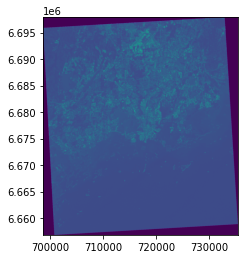

<AxesSubplot:>

In [14]:
rasterio.plot.show((raster,1))

Text(0.5, 1.0, 'Blue')

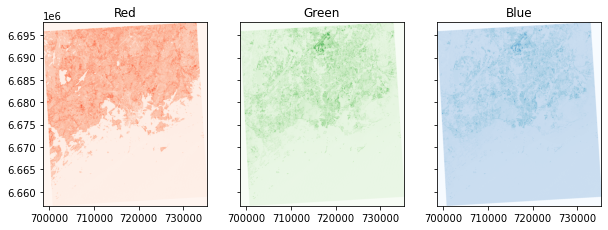

In [15]:
# Initialize subplots 
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(10, 4), sharey=True)

# Plot Red, Green and Blue (rgb)
rasterio.plot.show((raster, 4), cmap='Reds', ax=ax1)
rasterio.plot.show((raster, 3), cmap='Greens', ax=ax2)
rasterio.plot.show((raster, 1), cmap='Blues', ax=ax3)

# Add titles
ax1.set_title("Red")
ax2.set_title("Green")
ax3.set_title("Blue")

In [ ]:
# Raster Algebra

We often need to use the values from the raster in calculations. For example, we can try to calculate the NDVI (Normalized difference vegetation index) based on two bands: band-4 which is the Red channel and band-5 which is the Near Infrared (NIR).

In [20]:
# Read red channel (channel number 3)
red = raster.read(3)
# Read NIR channel (channel number 4)
nir = raster.read(4)

print(type(nir))
print(nir.dtype)


<class 'numpy.ndarray'>
uint8


In [17]:
# Convert to floats
red = red.astype('f4')
nir = nir.astype('f4')

# Avoid problems when dividing with zero
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [18]:
# Calculate NDVI using numpy arrays
ndvi = (nir - red) / (nir + red)

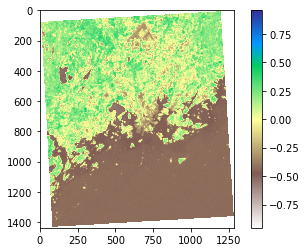

In [19]:
# Plot the NDVI
plt.imshow(ndvi, cmap='terrain_r')
# Add colorbar to show the index
plt.colorbar()

# Composing rasters together

In [ ]:
# we can use the merge module of rasterio
mosaic, out_trans = rasterio.merge.merge(list_of_open_raster_files)

# Copy the metadata
out_meta = src.meta.copy()

# Update the metadata
out_meta.update({"driver": "GTiff",
                 "height": mosaic.shape[1],
                 "width": mosaic.shape[2],
                 "transform": out_trans,
                 "crs": "+proj=utm +zone=35 +ellps=GRS80 +units=m +no_defs "
                 }
                )
# Write the mosaic raster to disk
with rasterio.open(out_filepath, "w", **out_meta) as dest:
    dest.write(mosaic)